# Alphavec Example - Simulate

This notebook demonstrates running `alphavec.simulate()` on the bundled feather datasets in `examples/data/`.

The weights were generated by a realworld systematic trading strategy.

Install the optional dependencies to run this notebook: `pip install -r requirements.dev.txt`

In [1]:
from pathlib import Path

from IPython.display import HTML, display
import pandas as pd

from alphavec import MarketData, SimConfig, simulate, tearsheet

## Load Data

In [2]:
data_dir = Path("./data")

weights = pd.read_feather(data_dir / "weights.feather")
close_prices = pd.read_feather(data_dir / "close_prices.feather")
open_prices = pd.read_feather(data_dir / "open_prices.feather")
funding_rates = pd.read_feather(data_dir / "funding_rates.feather")

display(weights.tail())
display(close_prices.tail())

symbols = weights.columns.tolist()
print("assets", len(symbols))
print("start", weights.index.min())
print("end", weights.index.max())

symbol,AAVE,ADA,AI,AI16Z,AIXBT,ALT,ANIME,APE,APT,AR,...,ZEN,ZEREBRO,ZK,ZORA,ZRO,kBONK,kFLOKI,kNEIRO,kPEPE,kSHIB
ts,,,,,,,,,,,,,,,,,,,,,
2025-12-02 00:00:00+00:00,NaN,-0.031875,NaN,NaN,NaN,NaN,NaN,NaN,-0.097401,0.029260,...,NaN,NaN,NaN,0.0,NaN,-0.008459,NaN,NaN,-0.000699,NaN
2025-12-03 00:00:00+00:00,NaN,-0.027453,NaN,NaN,NaN,NaN,NaN,NaN,-0.083888,0.025201,...,-0.112875,NaN,NaN,0.0,0.000131,0.000000,NaN,NaN,0.000000,NaN
2025-12-04 00:00:00+00:00,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.086195,0.025894,...,-0.115978,NaN,NaN,0.0,0.000135,NaN,NaN,NaN,NaN,NaN
2025-12-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.053187,0.015978,...,-0.071529,NaN,0.0,0.0,0.000083,NaN,NaN,NaN,NaN,NaN
2025-12-06 00:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.051574,0.000000,...,-0.069359,NaN,0.0,NaN,0.000081,NaN,NaN,NaN,NaN,NaN


symbol,AAVE,ADA,AI,AI16Z,AIXBT,ALT,ANIME,APE,APT,AR,...,ZEN,ZEREBRO,ZK,ZORA,ZRO,kBONK,kFLOKI,kNEIRO,kPEPE,kSHIB
ts,,,,,,,,,,,,,,,,,,,,,
2025-12-02 00:00:00+00:00,168.79,0.38834,NaN,NaN,0.039585,0.013016,0.006575,0.23618,1.8922,3.9386,...,9.6541,0.028973,0.033617,0.048958,1.3000,0.008721,0.043165,0.11868,0.004023,0.007918
2025-12-03 00:00:00+00:00,197.87,0.44952,NaN,NaN,0.043865,0.013717,0.006534,0.25134,2.0184,4.2969,...,9.4366,0.038904,0.038245,0.050670,1.4093,0.010014,0.049838,0.14077,0.004803,0.008968
2025-12-04 00:00:00+00:00,190.48,0.43922,NaN,NaN,0.043271,0.013139,0.006329,0.23680,1.9350,4.1867,...,9.5340,0.037351,0.037513,0.048951,1.3982,0.009621,0.047621,0.13732,0.004764,0.008697
2025-12-05 00:00:00+00:00,183.37,0.41582,NaN,NaN,0.040539,0.012715,0.006519,0.23167,1.7443,4.0007,...,8.6429,0.038500,0.033500,0.047205,1.3706,0.009068,0.044926,0.13049,0.004387,0.008298
2025-12-06 00:00:00+00:00,187.32,0.41342,NaN,NaN,0.042355,0.013159,0.006486,0.23631,1.7555,4.0015,...,8.5287,0.034134,0.033014,0.047661,1.3989,0.009380,0.046659,0.14057,0.004512,0.008415


assets 151
start 2023-01-01 00:00:00+00:00
end 2025-12-06 00:00:00+00:00


## Align Data

In [3]:
weights = weights.sort_index()

# Simulate requires that all given dataframes have the same index and columns as close_prices
assert weights.index.equals(close_prices.index)
assert weights.columns.equals(close_prices.columns)

# Drop leading periods before the strategy has any active (non-NaN) weights and align all dataframes
active_mask = weights.notna().any(axis=1)
weights = weights.loc[active_mask.idxmax() :]
close_prices = close_prices.loc[weights.index, weights.columns]
open_prices = open_prices.loc[weights.index, weights.columns]
funding_rates = funding_rates.loc[weights.index, weights.columns]

# Use next-period open as the execution price to avoid lookahead.
exec_prices = open_prices.shift(-1)

## Run Simulation

,Category,Value,Note
Metric,,,
Period frequency,Meta,1D,Interpretation: Sampling frequency used for annualization. Smaller periods are generally more granular (but can be noisier).
Benchmark Asset,Meta,BTC,Interpretation: Column name of the benchmark asset used for alpha/beta and benchmark charts (if provided).
Fee %,Meta,0.00025,Interpretation: Trading fee rate applied to order notional (decimal units; e.g. 0.001 = 10 bps).
Slippage %,Meta,0.001,Interpretation: Slippage applied against the trader on execution prices (decimal units; e.g. 0.001 = 10 bps).
Init Cash,Meta,10000.0,Interpretation: Initial cash (starting equity) used for the simulation.
Trading Days Year,Meta,365,Interpretation: Trading days per year used for annualization.
Risk Free Rate,Meta,0.03,Interpretation: Annual risk-free rate used for Sharpe/Sortino (decimal units).
Simulation start date,Meta,2023-08-09 00:00:00+00:00,Interpretation: First timestamp in the simulation index. Earlier start dates generally make estimates more statistically stable.
Simulation end date,Meta,2025-12-06 00:00:00+00:00,Interpretation: Last timestamp in the simulation index. More recent end dates generally better reflect current market conditions.

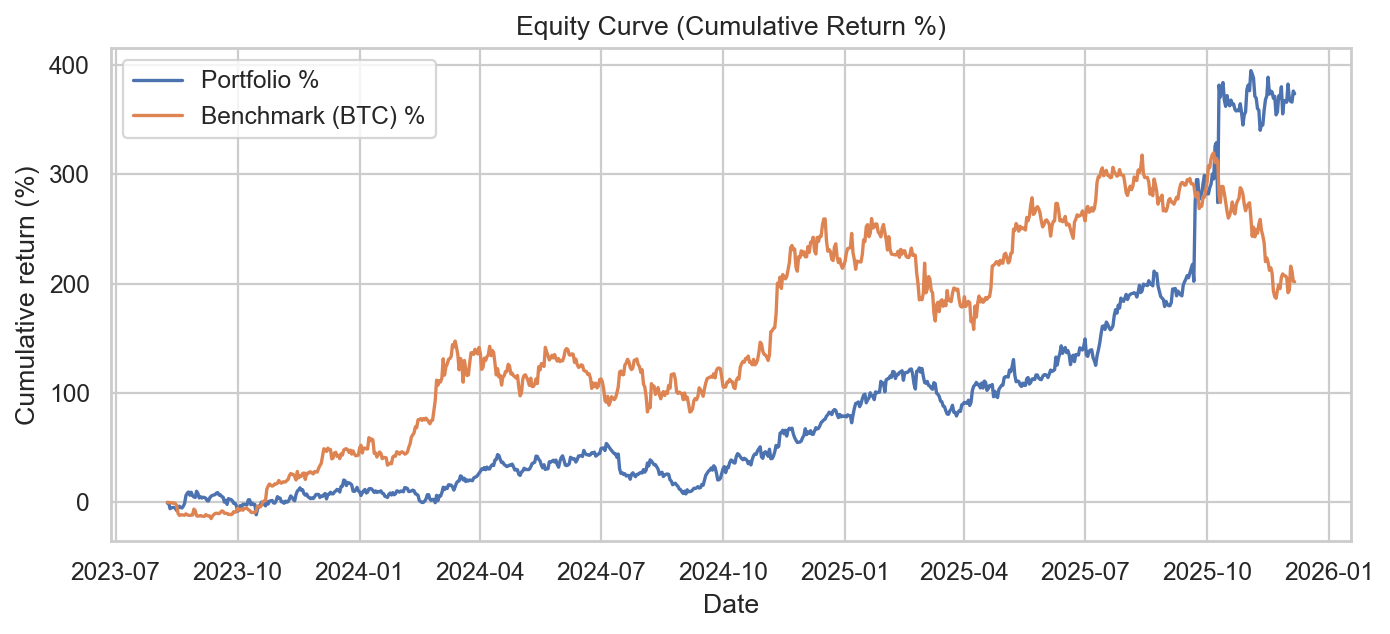
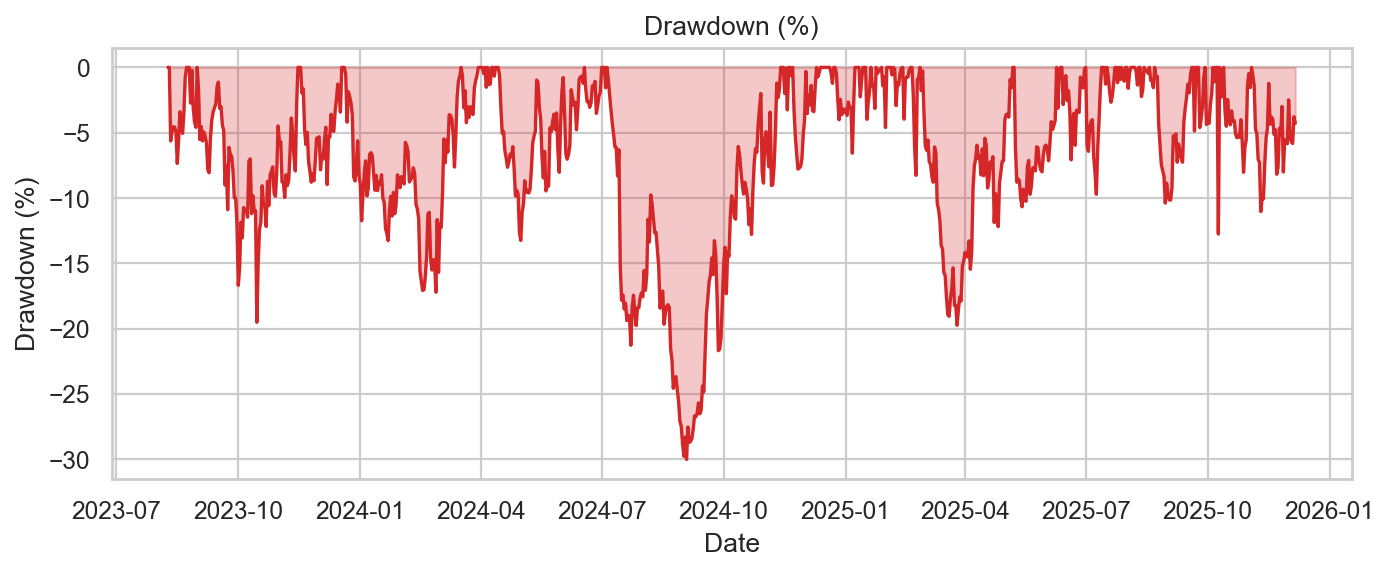
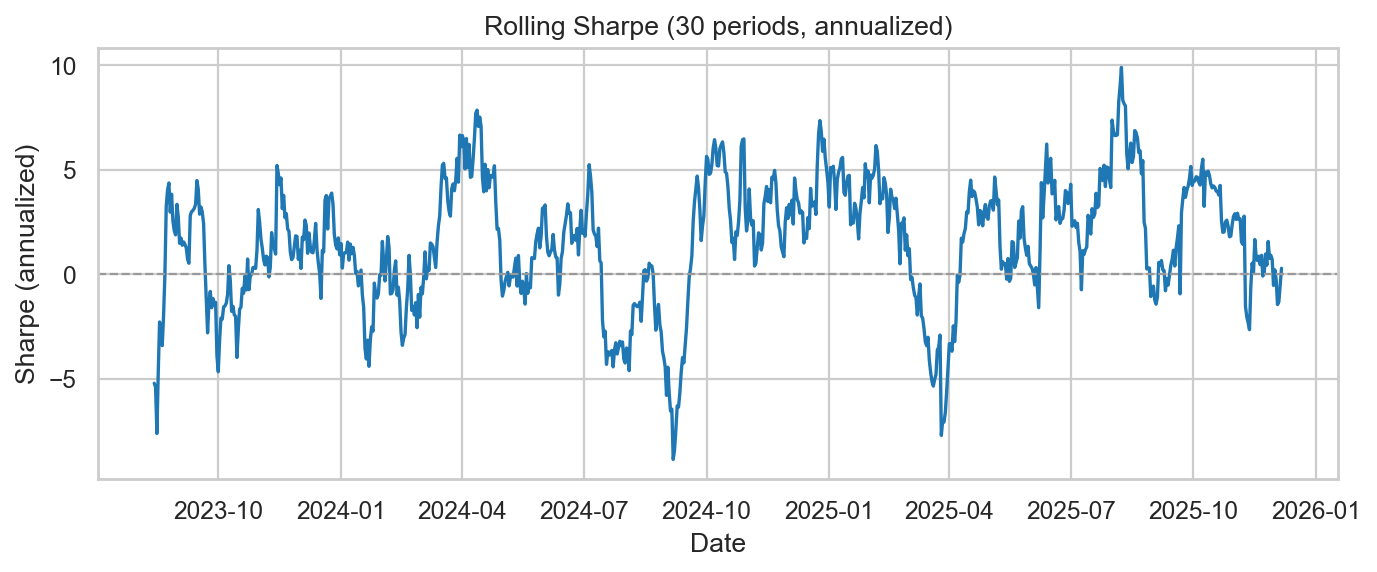
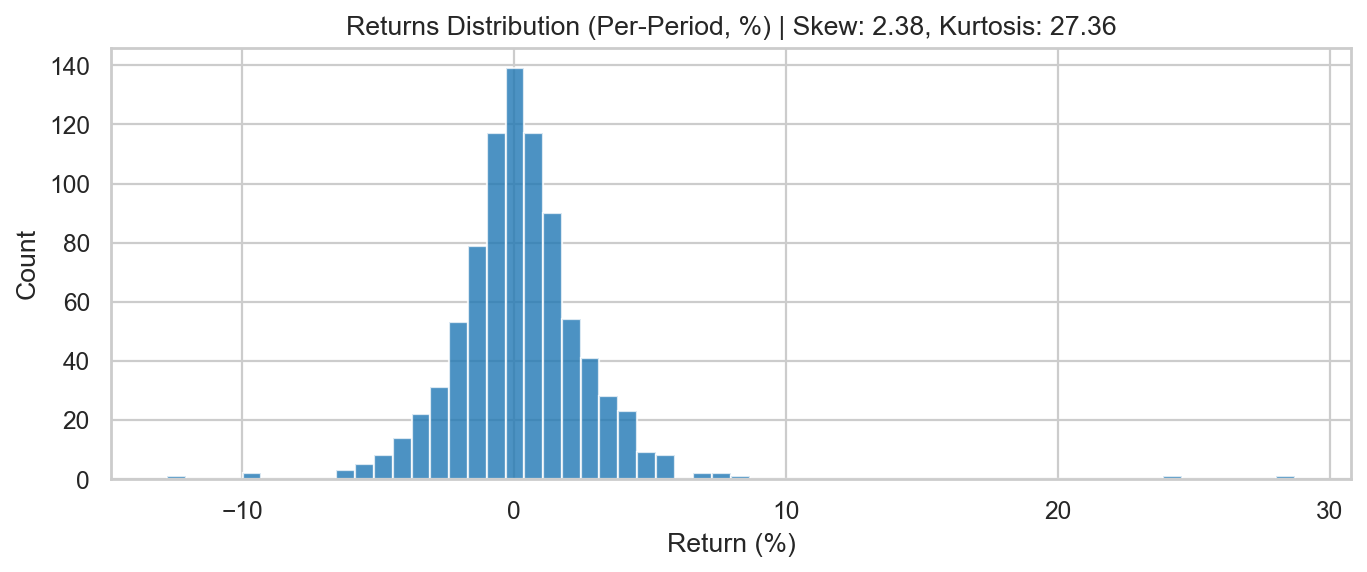
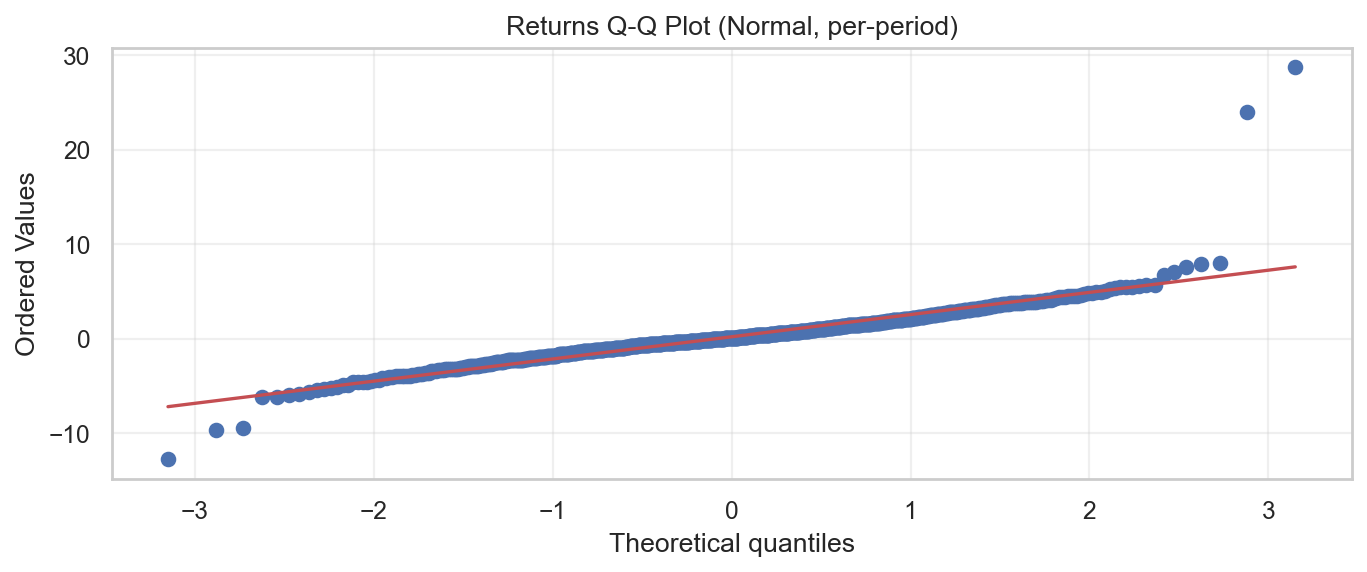
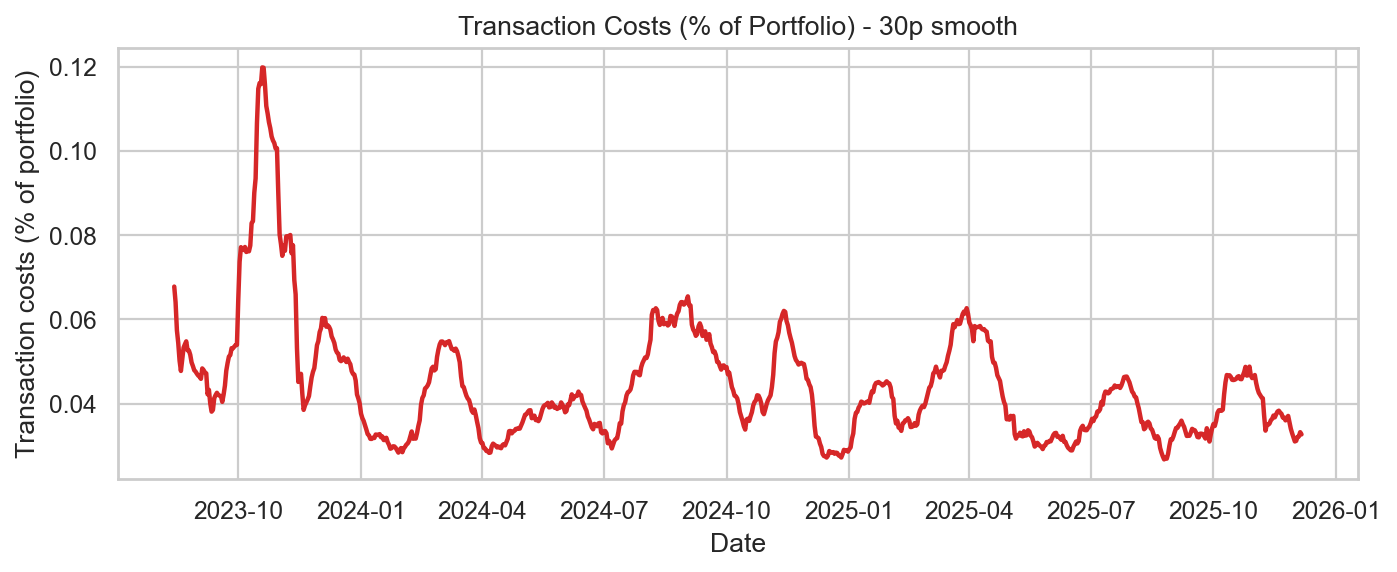
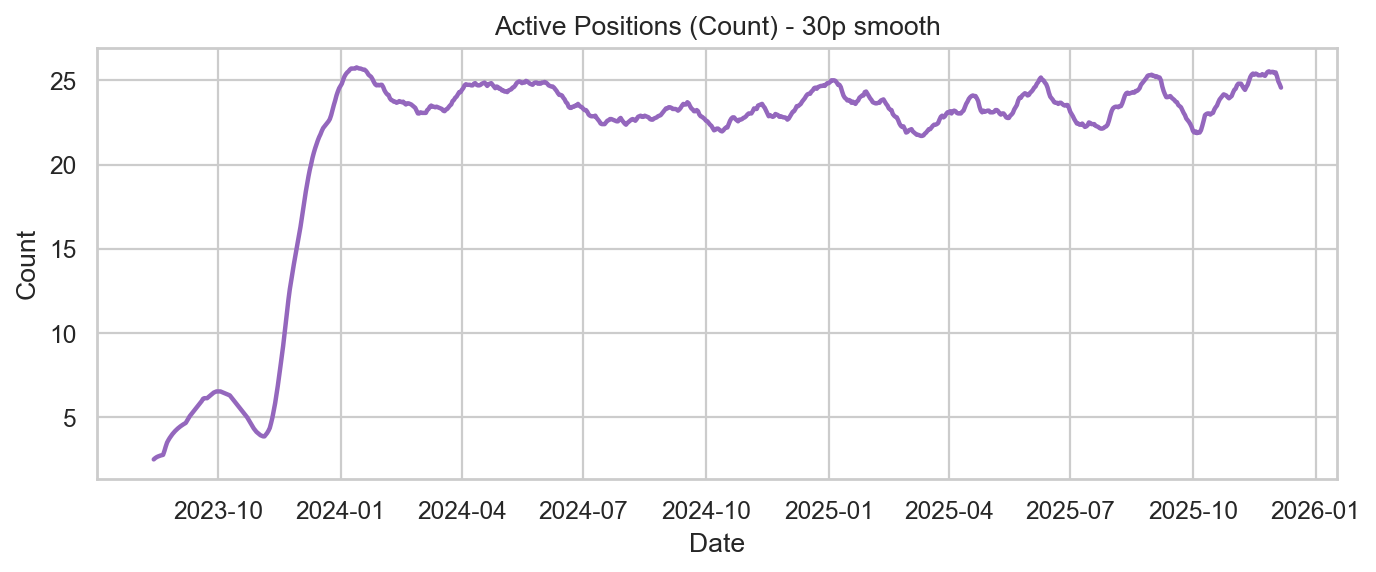
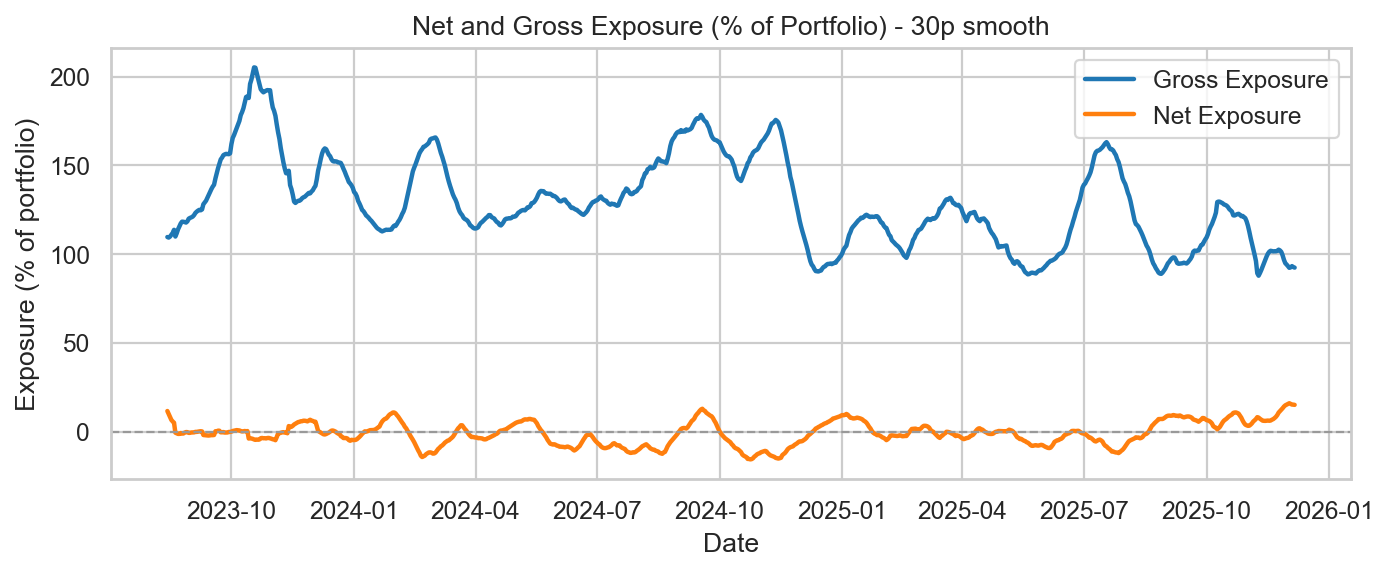
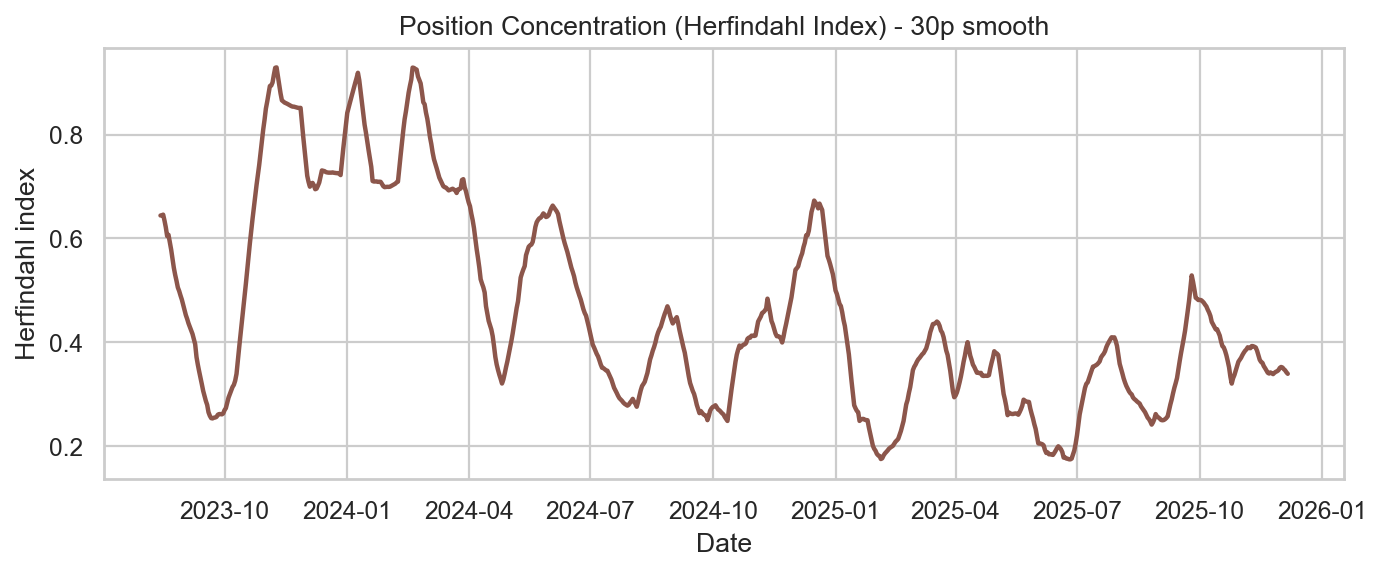
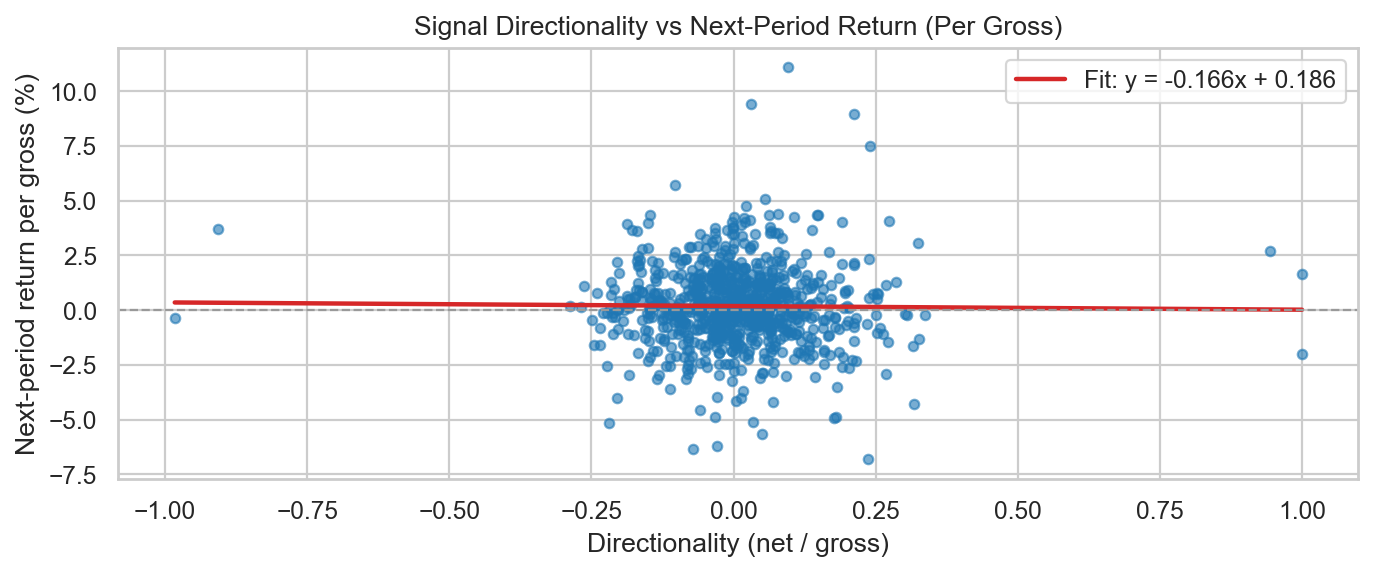
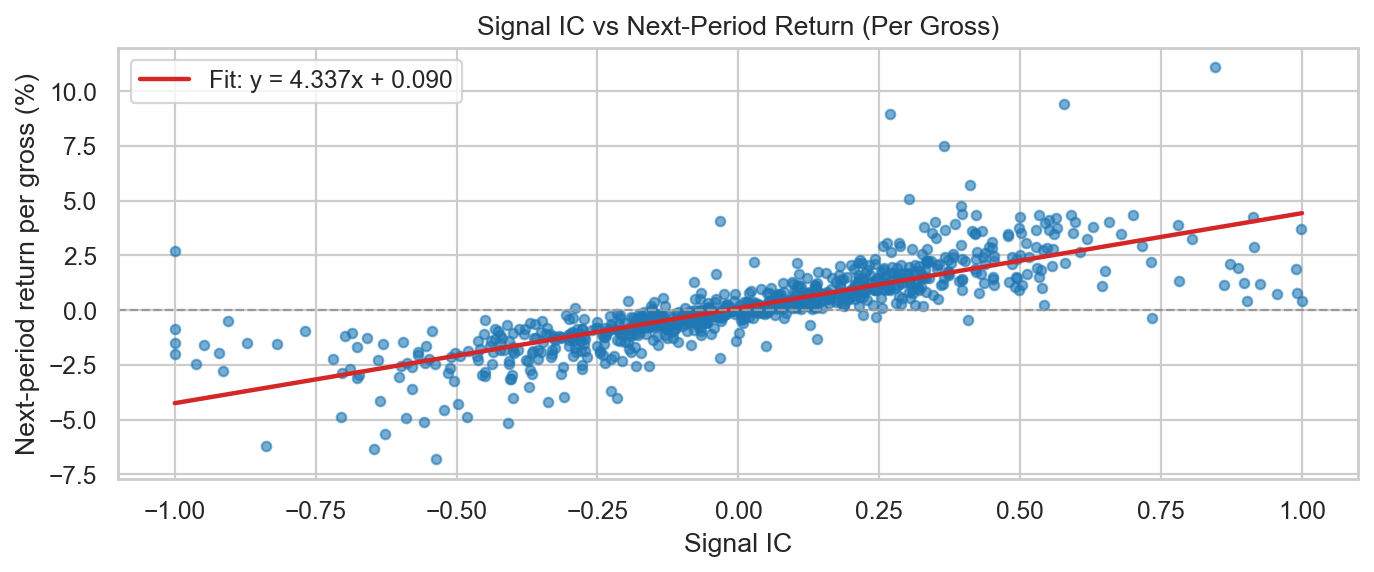
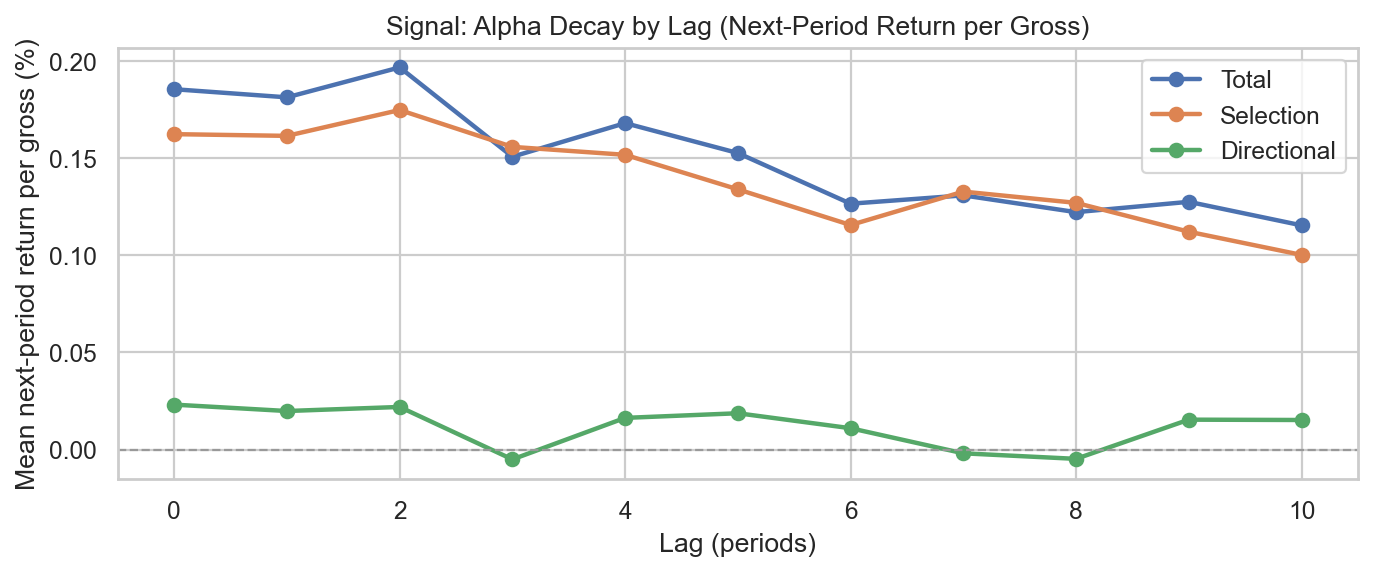
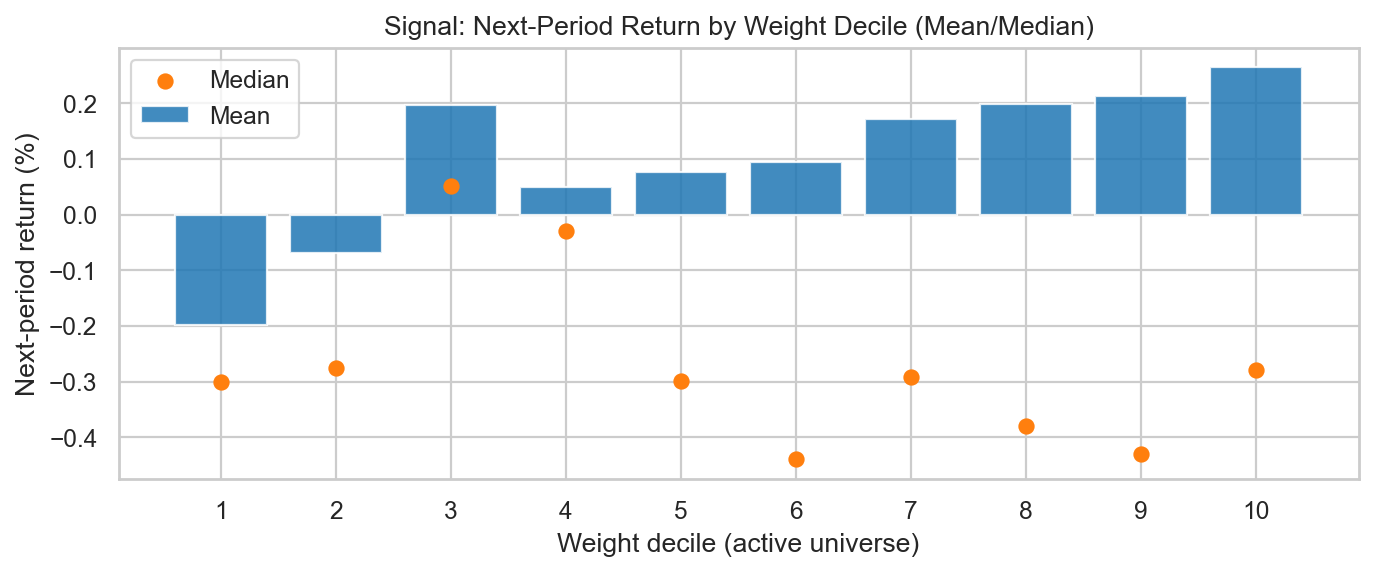
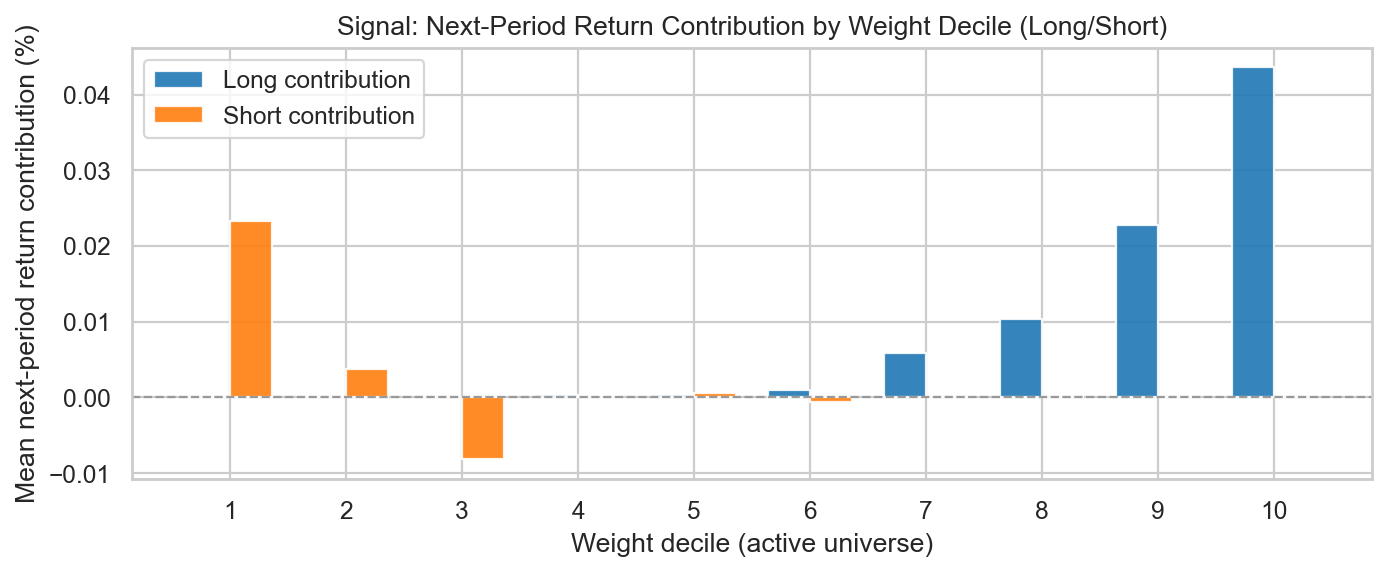

In [4]:
result = simulate(
    weights=weights,
    market=MarketData(
        close_prices=close_prices,
        exec_prices=exec_prices,
        funding_rates=funding_rates,
    ),
    config=SimConfig(
        benchmark_asset="BTC",
        order_notional_min=10,
        fee_rate=0.00025,      # 2.5 bps per trade
        slippage_rate=0.001,   # 10 bps per trade
        init_cash=10_000,
        freq_rule="1D",
        trading_days_year=365,
        risk_free_rate=0.03,
    ),
)

html_str = tearsheet(sim_result=result, output_path="simulate_tearsheet.html", smooth_periods=30)
display(HTML(html_str))
